## Test utility class to generate features from multiple files

In [1]:
import sys
sys.path.append('/home/zhay/DEEP/python/')
sys.path.append('/home/zhay/DEEP/python/lib/')
sys.path.append('/home/zhay/DEEP/python/machineLearning/')

import scipy as sp
import pandas as pd
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt
from scipy import signal
from StickSlipDetector import StickSlipDetector
from keras.models import Model,load_model, save_model
from keras.layers import Input,LSTM,Dense,Conv1D,MaxPooling1D,Dropout,BatchNormalization,Flatten
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import merge,concatenate
import keras
from keras_utility import precision, recall, binary_xentropy, fmeasure, augmentData,cut_to_batch
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import Adam
from IPython.display import SVG

import deep_util
import modeldef
from imp import reload
reload(deep_util)
reload(modeldef)

%matplotlib notebook

Using TensorFlow backend.


### Load data with feature generator

### Set processing parameters

In [2]:
trainingFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR30.p',
                  '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR31.p',
                  '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR32.p',
                  '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR34.p',
             ]

testFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR35.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR32.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR34.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR35.p'
             ]
# parameters to generate spectrogram
nfft=1024
nfftOverlap=nfft*0.9

# sampling rate of data
fs=100
dt=1/fs

# maximum frequency to look at 
freqMax=20

batchSize=32
conditionList=[['01_Global-Generic_Surface-copRigState',0,0],['01_Global-Generic_Surface-SRPM',50,1000],
#                ['01_Global-Generic_Surface-BIT_DEPTH', 8500/3.28,12500/3.28]
              ]
fg = deep_util.FeatureGenerator()
fg.setParam(nfft=nfft,nfftOverlap=nfftOverlap,freqMax=freqMax,batchSize=batchSize,conditionList=conditionList)

X_train,Y_train,auxDataDict_train=fg.GenerateFeatures(trainingFileList,conditionList,ytype='min',cutToBatch=True)
X_test,Y_test,auxDataDict_test=fg.GenerateFeatures(testFileList,conditionList,ytype='min',cutToBatch=True)


Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR30.p
reading 19532.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR31.p
reading 26738.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR32.p
reading 13200.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR34.p
reading 16624.000000 samples
Size of merged data X is: 
number of samples
76094
Shape of X (nsample,nt,nchannel):
(76094, 3000, 8)
 0 percent finished
10 percent finished
20 percent finished
30 percent finished
40 percent finished
50 percent finished
60 percent finished
70 percent finished
80 percent finished
90 percent finished
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_emsrpm_RR35.p
reading 22254.000000 samples
Size of merged data X i

In [3]:
auxDataDict_train

{'01_Global-Generic_Surface-BIT_DEPTH': array([ 1525.2034,  1525.851 ,  1526.4298, ...,  5222.9355,  5223.6456,
         5223.9617]),
 '01_Global-Generic_Surface-SRPM': array([ 59.982464,  59.81101 ,  60.096775, ...,  79.92899 ,  80.0433  ,
         79.986145]),
 '01_Global-Generic_Surface-SWOB': array([ 150821.26,  149696.3 ,  153279.44, ...,  126475.72,  134464.34,
         105833.28]),
 '01_Global-Generic_Surface-copROP': array([ 66.381782,  73.13737 ,  75.72695 , ...,  73.993248,  79.36992 ,
         41.221152]),
 '01_Global-Generic_Surface-copRigState': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}

In [4]:
Xt_train,Xs_train=X_train
Yt_train,Ys_train=Y_train

Xt_test,Xs_test=X_test
Yt_test,Ys_test=Y_test
print('training data shape')
print(Xt_train.shape)
print(Xs_train.shape)

print('test data shape')
print(Xt_test.shape)
print(Xs_test.shape)

# scaler.fit?

training data shape
(14400, 3000, 8, 1)
(14400, 20, 205, 8)
test data shape
(6016, 3000, 8, 1)
(6016, 20, 205, 8)


In [5]:
nsample_train=Xt_train.shape[0]
nsample_test=Xt_test.shape[0]

metaData_train=np.zeros((nsample_train,3))
metaData_train[:,0] = auxDataDict_train['01_Global-Generic_Surface-SRPM']
metaData_train[:,1] = auxDataDict_train['01_Global-Generic_Surface-SWOB']
metaData_train[:,2] = auxDataDict_train['01_Global-Generic_Surface-copROP']

metaData_test=np.zeros((nsample_test,3))
metaData_test[:,0] = auxDataDict_test['01_Global-Generic_Surface-SRPM']
metaData_test[:,1] = auxDataDict_test['01_Global-Generic_Surface-SWOB']
metaData_test[:,2] = auxDataDict_test['01_Global-Generic_Surface-copROP']
# metaData_train=np.zeros(nsample_train,3)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler=scaler.fit(metaData_train)
metaData_train_norm = scaler.transform(metaData_train)
metaData_test_norm = scaler.transform(metaData_test)


### Convert continuous target to class


In [46]:
lowLimit=-30
highLimit=200

# define class: RPM <0: class 1, RPM > high, 1, RPM in [low, high] 0. 
# training data
Y_catagory_train = np.zeros((Ys_train.shape))
Y_catagory_train[Ys_train<lowLimit]=1
Y_catagory_train[(Ys_train<highLimit) & (Ys_train >=lowLimit)]=0
# Y_catagory_train[Ys_train >=highLimit]=2
Y_catagory_train_onehot=keras.utils.to_categorical(Y_catagory_train)

# test data
Y_catagory_test = np.zeros((Ys_test.shape))
Y_catagory_test[Ys_test<lowLimit]=1
Y_catagory_test[(Ys_test<highLimit) & (Ys_test >=lowLimit)]=0
# Y_catagory_test[Ys_test >=highLimit]=2
Y_catagory_test_onehot=keras.utils.to_categorical(Y_catagory_test)

### Plot random example data and target 

<IPython.core.display.Javascript object>


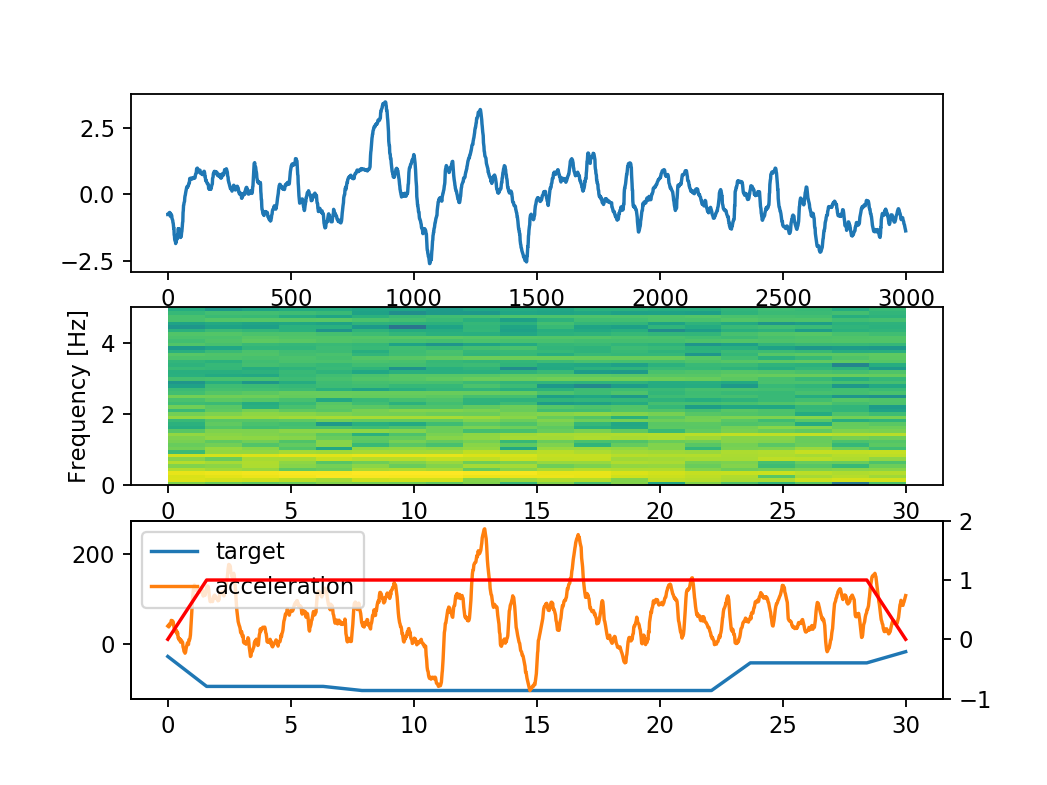

In [47]:
ntSpec,nf,nc=X_train[1][0].shape
ntSample,nc,_=X_train[0][0].shape
ichannel=0
# Plot random sample
# select data where y has a positive hit
idx_stick=np.where(np.min(Y_train[1],axis=1)<-40)[0]
# idx=np.random.randint(0,nsample)
idx=np.random.choice(idx_stick)

# plt.plot(X_time[m,:,1])
# plt.plot(X_time[m,:,3])

Xs_sample=X_train[1][idx,:,:,ichannel]
Xt_sample=X_train[0][idx,:,ichannel]

# Y_sample=Y_select[ind_strong][idx]
Ys_sample=Y_train[1][idx]
Yt_sample=Y_train[0][idx]

Y_class_sample = Y_catagory_train[idx]

# ------------------------

vf=np.linspace(0,freqMax,nf)
vt=np.linspace(0,ntSample*dt,ntSpec)
vt2=np.linspace(0,ntSample*dt,Xt_sample.shape[0])

plt.figure(dpi=150)
ax1=plt.subplot(311)
plt.plot(Xt_sample)

ax2=plt.subplot(312)
extents = vt[0], vt[-1],vf[0],vf[-1]

plt.imshow(10*np.log10(np.transpose(Xs_sample)),aspect='auto',origin='lower',extent=extents)
# plt.imshow(Xs_sample,aspect='auto',origin='lower',extent=extents)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.clim(40,80)
plt.ylim(0,5)

ax3=plt.subplot(313,sharex=ax2)
plt.plot(vt,Ys_sample,label='target')
plt.plot(vt2,Yt_sample,label='acceleration')

ax3b=ax3.twinx()
plt.plot(vt,Y_class_sample,'-r',label=' class label')
plt.ylim([-1,2])
# ax3b.legend()
ax3.legend()
# plt.suptitle(trainingDict['inputChannel'][ichannel])
plt.show()



In [8]:
from keras.layers import ZeroPadding2D,ZeroPadding1D
from keras.models import Sequential,Model,Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.core import Reshape, Permute
from keras.layers import Merge,concatenate,RepeatVector
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
def model_branched_cnn_mixed_lstm_classification_padding_meta(input1Shape, input2Shape, input3Shape,outputShape, numFilter=4, numUnitLSTM=16,batchSize=None,
                                                    stateful=False,
                                                    dropout=0):
    """model with mixed sampling rate and type
    input 1: (nsample, nt,nchannel,1) for time series
    input 2: (nsample, nt,nfreq,nchannel) for spectrogram
    """
    optimizer = 'adam'
    loss = 'categorical_crossentropy'
    kernelSize1 = (3, 3)
    kernelSize2 = (2, 5)
    
    ntOut = outputShape[0]
    nclassOut=outputShape[1]
    
    input1 = Input(batch_shape=(batchSize,) + input1Shape,name='timeseries')
    input2 = Input(batch_shape=(batchSize,) + input2Shape,name='spectrogram')
    aux_input = Input(batch_shape=(batchSize,) + input3Shape,name='auxdata')


    # -------------branch 1 : time series -----------------
    branch1 = Sequential()
    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same', batch_input_shape=(batchSize,) + input1Shape))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))

    branch1.add(Dropout(dropout))

    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same'))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))
    branch1.add(Dropout(dropout))

    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same'))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))
    #     reshape branch 1 input to match output time step: from (ntConv,nc,nfilter) to (ntOut,ntConv//ntConv*nc*nfilter)
    convOutShape1 = branch1.layers[-1].output_shape 
    branch1.add(Reshape((convOutShape1[1], np.prod(convOutShape1[2:4]))))
#     integer multiple of output shape

    nPadTo = int(np.ceil(convOutShape1[1]/ntOut)*ntOut)
    nPadding=(nPadTo-convOutShape1[1])
    branch1.add(ZeroPadding1D(padding=(0,nPadding)))
    print('original size: ')
    print(convOutShape1[1])
    print('padding to multiples of:')
    print(ntOut)
    
    print('new shape: ')
    print(branch1.layers[-1].output_shape)
    branch1.add(Reshape((ntOut, -1)))
    branch1.add(Dropout(dropout))

    # -------------branch 2 : spectrogram -----------------
    branch2 = Sequential()
    branch2.add(Convolution2D(numFilter, kernelSize2, padding='same', batch_input_shape=(batchSize,) + input2Shape))
    branch2.add(MaxPooling2D(pool_size=(1, 2)))
    branch2.add(Activation('relu'))
    branch2.add(Dropout(dropout))
    branch2.add(Convolution2D(numFilter, kernelSize2, padding='same'))
    branch2.add(MaxPooling2D(pool_size=(1, 2)))
    branch2.add(Activation('relu'))
    convOutShape2 = branch2.layers[-1].output_shape
    branch2.add(Reshape((convOutShape2[1], np.prod(convOutShape2[2:4]))))

    branch2.add(Dropout(dropout))
    output1 = branch1(input1)
    output2 = branch2(input2)

    #     model = Sequential()

    # -------------merge branch 1 with branch 2 -----------------
    #     model.add(keras.layers.merge.concatenate([branch1, branch2], mode='concat', concat_axis=2))
    #     model.add(concatenate([branch1,branch2],axis=2))
    mergedInput = concatenate([output1, output2], axis=2)

    #     keras.layers.concatenate
    #     convOutShape = model.layers[-1].output_shape
    #     model.add(Reshape((np.prod(convOutShape[1:3]), convOutShape[3])))
    #     model.add(Permute((2, 1)))
    #     model.add(LSTM(48, return_sequences=True, stateful=True))
    X = LSTM(numUnitLSTM, return_sequences=True, stateful=stateful)(mergedInput)
    X=Dropout(dropout)(X)
    #     model.add(LSTM(48, return_sequences=True))
    X = LSTM(numUnitLSTM, return_sequences=True)(X)
    X=Dropout(dropout)(X)

    #     model.add(TimeDistributed(Dense(1)))
#     -----------------aux input-------------------
    aux_input_repeat=RepeatVector(ntOut)(aux_input)
    X_merge_aux = concatenate([X, aux_input_repeat])
    
    output = TimeDistributed(Dense(nclassOut,activation='softmax'))(X_merge_aux)
#     model.add(Activation('softmax'))

    model = Model(inputs=[input1, input2,aux_input], outputs=output)

    return model, optimizer, loss

In [48]:
# Define custom metrics
from keras import backend as K

def r2_score(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2


def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [49]:
# A function to return batches with ramdom samples from each class with certain weights

def BalancedDataGenerator_weighted(features, labels, batch_size,classPropability=[1,1]):
#     np.sum(labels,axis=(0,1))/np.sum(labels)
    feature1,feature2,feature3 = features
    
    #   maximum catagory for this sample
    maxClass=np.max(np.argmax(labels,axis=2),axis=1)
    nclass=len(classPropability)
    idx_list=[]
    prob = [p/sum(classPropability) for p in classPropability]
#     list of index corresponding to each class
    for i in range(nclass):
        idx_list.append(np.where(maxClass==i)[0])
    
    while True:
        batch_feature1=np.zeros((batchSize,)+feature1.shape[1:])
        batch_feature2=np.zeros((batchSize,)+feature2.shape[1:])
        batch_feature3=np.zeros((batchSize,)+feature3.shape[1:])
        batch_labels=np.zeros((batchSize,)+labels.shape[1:])
        
        for i in range(batch_size):
#           randomly select class with probabilility
            iclass=np.random.choice(np.arange(nclass),p=prob)         
    
#           ramdonly select a sample within a certain class
            index = np.random.choice(idx_list[iclass],1)

            batch_feature1[i]=feature1[index]
            batch_feature2[i]=feature2[index]
            batch_feature3[i]=feature3[index]
            batch_labels[i]=labels[index]
            
        yield [batch_feature1,batch_feature2,batch_feature3],batch_labels

### Build model

In [51]:
from modeldef import model_branched_cnn_mixed_lstm_regression_functional
# from dataGenerator import BalancedDataGenerator_binary
import dataGenerator
reload(dataGenerator)
# from modeldef import model_branched_cnn_mixed_lstm_regression_padding
nt,nf,nc=X_train[0][0].shape
inputShape1=X_train[0].shape[1:]
inputShape2=X_train[1].shape[1:]
inputShape3=metaData_train_norm.shape[1:]

# inputShape2=(20, 205, 8)
# outputShape=Y_train[1].shape[1:]
outputShape=Y_catagory_train_onehot.shape[1:]

# outputShape=(20,1)
# batchSize=32

numFilter=[4]
nUnitLSTM=[8,16]
dropoutRate=[0.1,0.3]


modelList=[]
historyList=[]
scoreList=[]

Feature_train=[X_train[0],X_train[1],metaData_train_norm]
Feature_test=[X_test[0],X_test[1],metaData_test_norm]

Target_train=Y_catagory_train_onehot
Target_test=Y_catagory_test_onehot

# X_train=[Xt_train,Xs_train]
# X_test=[Xt_test,Xs_test]

# for nf in numFilter:
ParamList=[[a,b] for a in nUnitLSTM for b in dropoutRate ]

# for nlstm in nUnitLSTM:
for nlstm, dropOutRate in ParamList:
    print('----------LSTM UNIT = %3f------------'%nlstm)
    print('----------dropOut Rate = %1.2f------------'%dropOutRate)
    
    model, optimizer, loss=model_branched_cnn_mixed_lstm_classification_padding_meta(
                                                                input1Shape=inputShape1, input2Shape=inputShape2,
                                                                input3Shape=inputShape3,
                                                                outputShape=outputShape,stateful=False,
                                                                numFilter=numFilter[0], numUnitLSTM=nlstm, batchSize=batchSize,
                                                                dropout=dropOutRate)
#     model, optimizer, loss=model_branched_cnn_mixed_lstm_regression_functional(
#                                                                 input1Shape=inputShape1, input2Shape=inputShape2, 
#                                                                 outputShape=outputShape,stateful=False,
#                                                                 numFilter=nf, batchSize=batchSize,dropout=0.5)
    model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy',precision,recall])
#     model.compile(loss='mae',optimizer=optimizer,metrics=['mse',r2_keras])

    earlyStop=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0,
                              patience=5,
                              verbose=0, mode='auto')
    model.summary()

    print('size of first branch training data: ' + str(Feature_train[0].shape))
    print('size of second branch training data: ' + str(Feature_train[1].shape))

#     class_weight={0:1,1:2,2:5}
#     generator_train=BalancedDataGenerator_weighted(features=Feature_train,labels=Target_train,
#                                                    batch_size=batchSize,classPropability=[2,1])


    maxClass = np.max(np.argmax(Target_train, axis=2), axis=1)
#     generator_train = dataGenerator.BalancedDataGenerator_binary(features=Feature_train,labels=Target_train,scalerLabel=maxClass,
#                                    batch_size=batchSize,shuffle=True,classProbability=[1,1])
    generator_train = dataGenerator.BalancedDataGenerator_multifeature(features=Feature_train,labels=Target_train,scalerLabel=maxClass,
                                   batch_size=batchSize,shuffle=True,classProbability=[1,1])    
#     generator_test=BalancedDataGenerator_weighted(features=Feature_test,labels=Target_test,
#                                                    batch_size=batchSize,classPropability=[1,1,1])
        
    History=model.fit_generator(generator_train,
                                epochs=30,
#                                 steps_per_epoch=600,
                                validation_data=(Feature_test,Target_test),
#                                 validation_data=generator_test,
#                                 validation_steps=int(nsample_test/batchSize),
                                callbacks=[earlyStop],
                                shuffle=True,verbose=1)
#     History=model.fit(Feature_train, Target_train,
#                   batch_size=batchSize, 
#                   epochs=30,
#                   validation_data=(Feature_test,Target_test),
#                   callbacks=[earlyStop],
#                   shuffle=True,verbose=1)

#     Y_predict_train=model.predict(Feature_train,verbose=1)
    Y_predict_test=model.predict(Feature_test,verbose=1)
    
#     r2_train=r2Coeff(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1))
#     r2_test=r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))    
    
    score=model.evaluate(Feature_test,Target_test)
#     score.append(r2_train)
#     score.append(r2_test)
    
# ssd.setModelParameters(lr=0.001,strides=4,poolingSize=4,nfilter=nfilter,filterLength=filterLength,patience=10)
# model=multiChannelTimeSeriesModel(input_shape=(nc,nt),nUnitRNN=16,numClasses=2)
# model, optimizer, loss=modeldef.model_cnn_lstm_adam_binary(inputShape=(nt,nf,nc), batchSize=batchSize)
# model, optimizer, loss=modeldef.model_cnn_lstm_adam_binary_dropout(inputShape=(nt,nf,nc), batchSize=batchSize,dropout=0.4)

# model, optimizer, loss=model_cnn_lstm_adam(inputShape=(nt,nf,nc), numClasses=1, batchSize=batchSize)
# model, optimizer, loss=model_cnn_lstm_adam_functional(inputShape=(nt,nf,nc), numClasses=1, batchSize=batchSize)
# branch1.summary()
# branch2.summary()
    modelList.append(model)
    historyList.append(History)
    scoreList.append(score)


----------LSTM UNIT = 8.000000------------
----------dropOut Rate = 0.10------------
original size: 
375
padding to multiples of:
20
new shape: 
(32, 380, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         (32, 3000, 8, 1)     0                                            
__________________________________________________________________________________________________
spectrogram (InputLayer)        (32, 20, 205, 8)     0                                            
__________________________________________________________________________________________________
sequential_39 (Sequential)      (32, 20, 608)        336         timeseries[0][0]                 
__________________________________________________________________________________________________
sequential_40 (Sequential)      (32, 20, 204)    

KeyboardInterrupt: 

In [112]:
# len(generator_train.x)
len(list(set(generator_train.index_batch)))


32

In [37]:
for l in model.layers:
    print(l.name)
#     print(l.input_shape)
    print(l.output_shape)
model.layers[2].summary()
model.layers[3].summary()
outputShape

timeseries
(32, 3000, 8, 1)
spectrogram
(32, 20, 205, 8)
sequential_3
(32, 20, 608)
sequential_4
(32, 20, 204)
concatenate_3
(32, 20, 812)
lstm_3
(32, 20, 8)
dropout_13
(32, 20, 8)
lstm_4
(32, 20, 8)
auxdata
(32, 3)
dropout_14
(32, 20, 8)
repeat_vector_2
(32, 20, 3)
concatenate_4
(32, 20, 11)
time_distributed_2
(32, 20, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (32, 3000, 8, 4)          40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 1500, 8, 4)          0         
_________________________________________________________________
activation_6 (Activation)    (32, 1500, 8, 4)          0         
_________________________________________________________________
dropout_8 (Dropout)          (32, 1500, 8, 4)          0         
_________________________________________________________________
conv2d_7 (Conv2

(20, 2)

### Compile model

In [17]:
[score[1:4] for score in scoreList]

[[0.82944647682474015, 0.82944647682474015, 0.82944647682474015],
 [0.83768284558615791, 0.83768284558615791, 0.83768284558615791],
 [0.80377327175216473, 0.80377327175216473, 0.80377327175216473],
 [0.79999168851274127, 0.79999168851274127, 0.79999168851274127],
 [0.83985206120191735, 0.83985206120191735, 0.83985206120191735],
 [0.82761801969497761, 0.82761801969497761, 0.82761801969497761],
 [0.81043052007543281, 0.81043052007543281, 0.81043052007543281],
 [0.8484624323058636, 0.8484624323058636, 0.8484624323058636],
 [0.85043218398981901, 0.85043218398981901, 0.85043218398981901],
 [0.8248919543433697, 0.8248919543433697, 0.8248919543433697],
 [0.83834773983727107, 0.83834773983727107, 0.83834773983727107],
 [0.84571143857976228, 0.84571143857976228, 0.84571143857976228],
 [0.84542885612934193, 0.84542885612934193, 0.84542885612934193],
 [0.83899600787999784, 0.83899600787999784, 0.83899600787999784],
 [0.82270611743343636, 0.82270611743343636, 0.82270611743343636],
 [0.825024932939

In [148]:
Y_predict_test[3]

array([[ 0.48984915,  0.51015085],
       [ 0.49451622,  0.50548375],
       [ 0.5261938 ,  0.4738062 ],
       [ 0.56063855,  0.43936145],
       [ 0.56358492,  0.43641505],
       [ 0.54888743,  0.45111254],
       [ 0.50695425,  0.49304575],
       [ 0.46034634,  0.5396536 ],
       [ 0.43181491,  0.56818515],
       [ 0.40001112,  0.59998888],
       [ 0.34315461,  0.65684539],
       [ 0.28057837,  0.71942157],
       [ 0.24046293,  0.7595371 ],
       [ 0.22653419,  0.77346581],
       [ 0.24052717,  0.75947279],
       [ 0.27009046,  0.72990954],
       [ 0.30361816,  0.69638187],
       [ 0.32487342,  0.67512655],
       [ 0.37552911,  0.62447089],
       [ 0.42676339,  0.57323658]], dtype=float32)

<IPython.core.display.Javascript object>


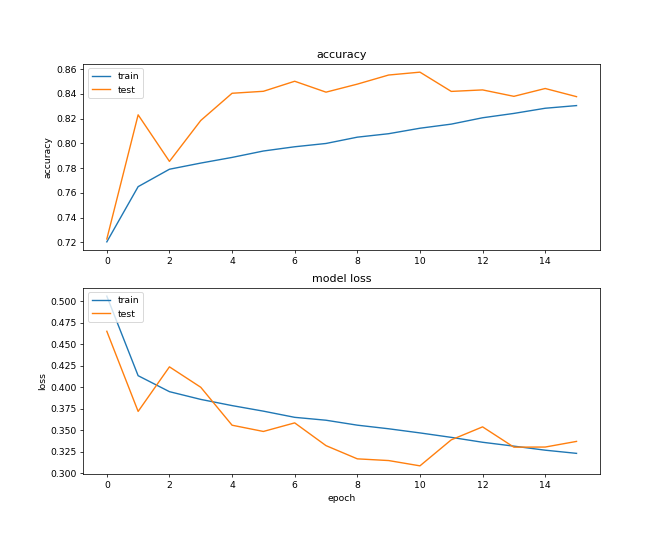

In [36]:
imodel=1
History=historyList[imodel]
model=modelList[imodel]
# Training history
fig=plt.figure(figsize=[10,8])
# fig.set_size_inches(12,10)
ax1=plt.subplot(211)
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
#plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# fig=plt.figure(figsize=[12,10])


ax2=plt.subplot(212)
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Training history
# fig=plt.figure(figsize=[10,8])
# # fig.set_size_inches(12,10)
# ax1=plt.subplot(211)
# plt.plot(History.history['mean_squared_error'])
# plt.plot(History.history['val_mean_squared_error'])
# plt.title('model mean square error')
# plt.ylabel('mae')
# #plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# # plt.show()

# # fig=plt.figure(figsize=[12,10])


# ax2=plt.subplot(212)
# # summarize history for loss
# plt.plot(History.history['loss'])
# plt.plot(History.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [37]:
Y_prob_train = model.predict(Feature_train,verbose=1)
Y_predict_train=np.argmax(Y_prob_train,axis=2)
prob_ss_train = Y_prob_train[:,:,1]

Y_prob_test = model.predict(Feature_test,verbose=1)
Y_predict_test=np.argmax(Y_prob_test,axis=2)
prob_ss_test = Y_prob_test[:,:,1]

6016/6016 [==============================] - 7s 1ms/step


In [38]:
# model=modelList[0]
# plot test example
Xs_plot=X_test[1]
Xt_plot=X_test[0]
Ys_plot=Y_test[1]
Yt_plot=Y_test[0]
Y_predict = Y_predict_test
Y_catagory_plot=Y_catagory_test

# plot training example
# Xs_plot=X_train[1]
# Xt_plot=X_train[0]
# Ys_plot=Y_train[1]
# Yt_plot=Y_train[0]
# Y_predict = Y_predict_train
# Y_catagory_plot=Y_catagory_train


# Y_predict=model.predict(X_plot,verbose=1)



<IPython.core.display.Javascript object>


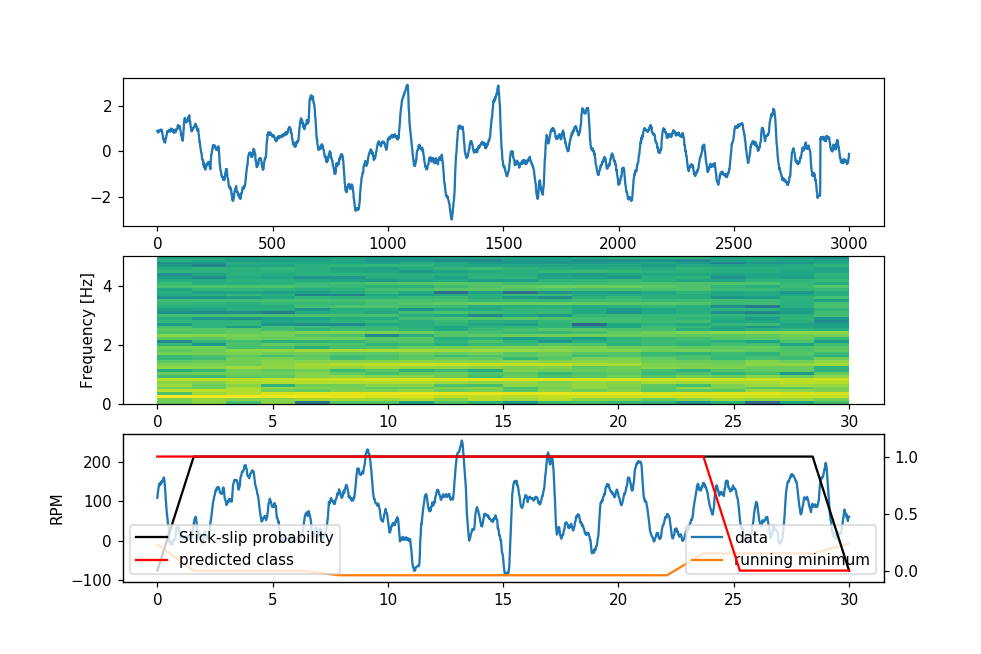

In [42]:
# Plot random sample
ichannel=0
nsample=Xs_plot.shape[0]
idx=np.random.randint(0,nsample)

# select from subset of samples containing positive labels
# select data where y has a positive hit
idx_stick=np.where(np.min(Ys_plot,axis=1)<-50)[0]
# idx_stick=np.where((np.max(np.abs(Ys_plot-Y_predict),axis=1)<1) & (np.max(Ys_plot,axis=1)>2))[0]

# idx_stick=np.where(np.max(np.round(Y_predict),axis=1)>0)[0]

# idx=np.random.randint(0,nsample)
idx=np.random.choice(idx_stick)

Xs_sample=Xs_plot[idx,:,:,ichannel]
Xt_sample=Xt_plot[idx,:,ichannel]

Ys_sample=Ys_plot[idx]
Yt_sample=Yt_plot[idx]

Y_class_sample = Y_catagory_plot[idx]
Y_class_predict = Y_predict[idx]
Y_ss_prob=prob_ss_test[idx]

# plt.figure(dpi=150)
plt.figure(figsize=[9,6])
ax1=plt.subplot(311)
plt.plot(Xt_sample)
# plt.plot(X_time[m,:,1])
# plt.plot(X_time[m,:,3])


# Y_b = Y_binary[idx]
vf=np.linspace(0,freqMax,nf)
vt=np.linspace(0,ntSample*dt,ntSpec)
vt2=np.linspace(0,ntSample*dt,Xt_sample.shape[0])


ax2=plt.subplot(312)
extents = vt[0], vt[-1],vf[0],vf[-1]

plt.imshow(10*np.log10(np.transpose(Xs_sample)),aspect='auto',origin='lower',extent=extents)
# plt.imshow(Xs_sample,aspect='auto',origin='lower',extent=extents)
# plt.plot([vt[0],vt[-1]],[freqLimit,freqLimit],'-r')

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.clim(40,80)
plt.ylim(0,5)

ax3=plt.subplot(313,sharex=ax2)


plt.plot(vt2,Yt_sample,label='data')
# plt.plot(vt2,Yt_sample,'o',label='lat accel')
plt.ylabel('RPM')

plt.plot(vt,Ys_sample,label='running minimum')
# plt.plot(vt,Y_predict[idx].ravel(),'-ro',label='predicted target')
# plt.plot(vt,np.round(Y_predict[idx].ravel()+0.4),'-go',label='predicted target')
# plt.ylabel('target')

# ax3b.legend(loc=3)
ax3.legend(loc=4)
# plt.ylim(-0.1,10)
ax3b=ax3.twinx()
plt.plot(vt,Y_class_sample,'-k',label='Stick-slip probability')
# plt.plot(vt,Y_ss_prob,'-k',label='Stick-slip probability')

plt.plot(vt,Y_class_predict,'-r',label='predicted class')
ax3b.legend(loc=3)

plt.ylim(-0.1,1.2)

# plt.suptitle(trainingDict['inputChannel'][ichannel])
plt.show()






### Plot confusion matrix

<IPython.core.display.Javascript object>


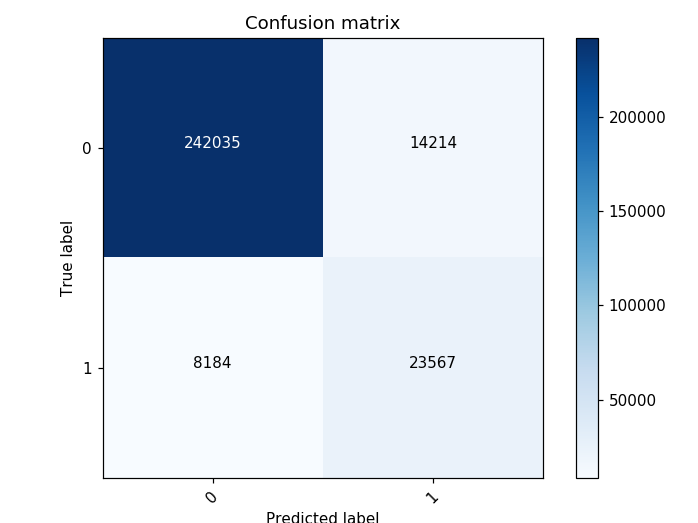

Confusion matrix, without normalization
[[242035  14214]
 [  8184  23567]]


<IPython.core.display.Javascript object>


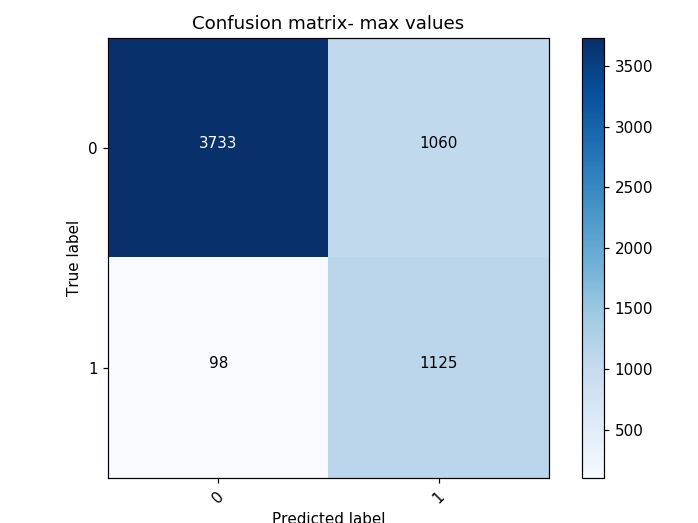

Confusion matrix, without normalization
[[3733 1060]
 [  98 1125]]


In [45]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# cm=confusion_matrix(Y_catagory_test.ravel(),Y_predict_test.ravel())
cm=confusion_matrix(Y_catagory_train.ravel(),Y_predict_train.ravel())

plt.figure()
plot_confusion_matrix(cm, classes=['0','1'],
                      title='Confusion matrix')


cm_max=confusion_matrix(np.max(Y_catagory_plot,axis=1),np.max(Y_predict,axis=1))
plt.figure()
plot_confusion_matrix(cm_max, classes=['0','1'],
                      title='Confusion matrix- max values')

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
threshold = 0.5
print('---------classification report:  all values---------')

print(classification_report(Y_catagory_plot.ravel(), np.round(Y_predict.ravel()+0.5-threshold), target_names=['0','1']))

print('---------classification report:  maximum value---------')
print(classification_report(np.max(Y_catagory_plot,axis=1),np.max(Y_predict,axis=1), target_names=['0','1']))


---------classification report:  all values---------
             precision    recall  f1-score   support

          0       0.95      0.86      0.90    106417
          1       0.39      0.68      0.49     13903

avg / total       0.89      0.84      0.86    120320

---------classification report:  maximum value---------
             precision    recall  f1-score   support

          0       0.97      0.78      0.87      4793
          1       0.51      0.92      0.66      1223

avg / total       0.88      0.81      0.82      6016



### Cross-plotting data vs prediction 

### Plot model prediction with Depth

In [95]:
np.mean((Ys_plot-Y_predict_test)**2)

0.88673015417349998

In [96]:
def r2Coeff(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2

In [97]:
# r2Coeff(Ys_train,Y_predict_train)
r2_train=r2Coeff(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1))
r2_test=r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))

<IPython.core.display.Javascript object>


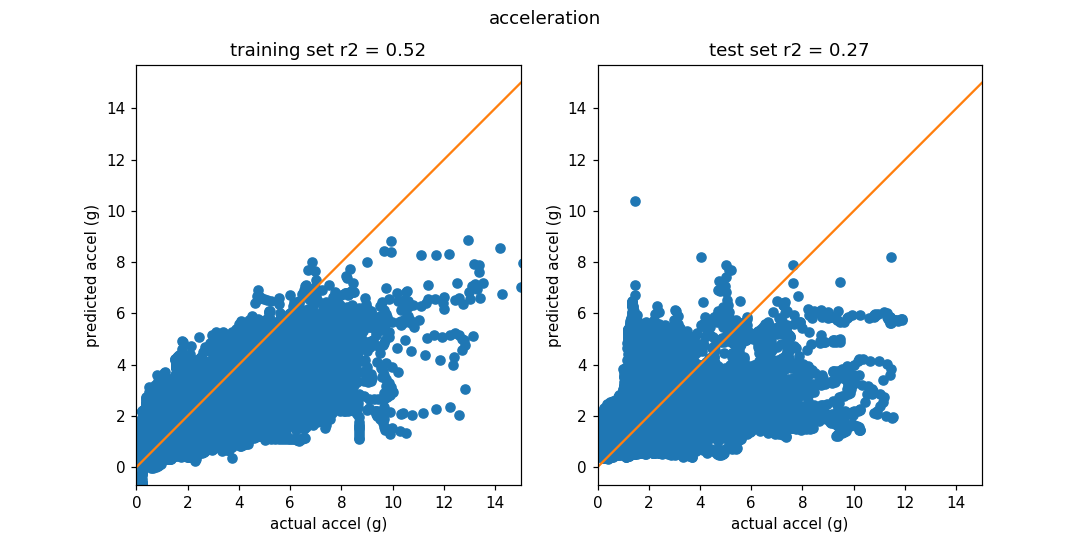

<IPython.core.display.Javascript object>


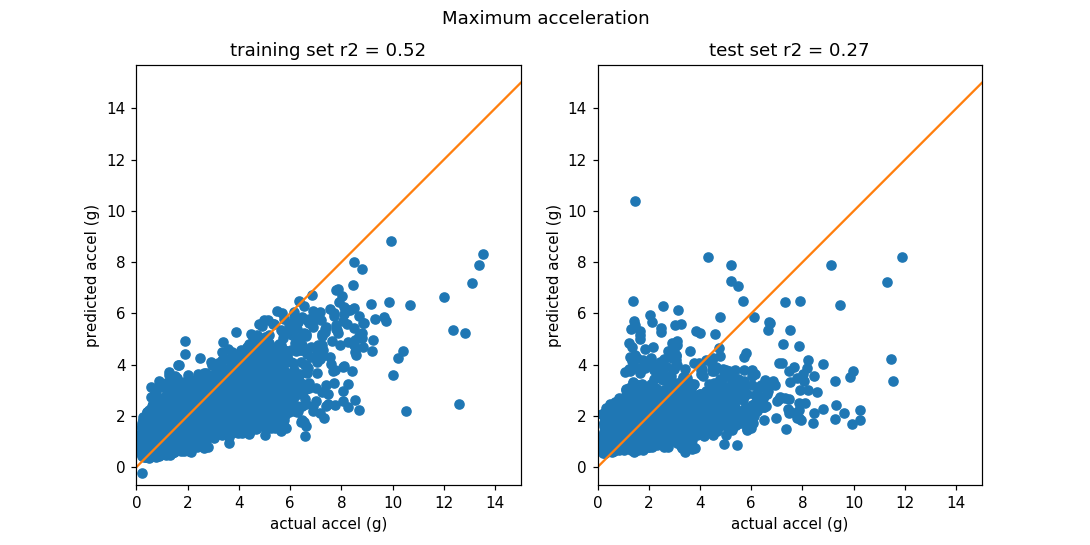

Text(0.5,0.98,'Maximum acceleration')

In [98]:
# Plotting statistics 
plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
plt.plot(Ys_train.ravel(),Y_predict_train.ravel(),'o')
# plt.plot(accel0*Y_predict.ravel(),accel0*Ys_plot.ravel(),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(Ys_test.ravel(),Y_predict_test.ravel(),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('acceleration')

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(accel0*Ys_train.ravel(),accel0*Y_predict_train.ravel(),'o')
plt.plot(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('Maximum acceleration')

### Plot with depth

### Save model

In [347]:
imodel=np.argmin([score[0] for score in scoreList])
#imodel=np.argmax([score[2] for score in scoreList])

model=modelList[imodel]
param=ParamList[imodel]
# model_name = 'regression_8channel_30s_50Hz_separateData.h5'
model_name = 'models/regression_8channel_30s_all_rpm'+str(freqMax)+'Hz_separateData_nlstm='+str(param[0])+'_dropout='+str(param[1])
# model.save(model_name)

# Save as Json and weights
# Save model
json_name=model_name+'.json'
model_json = model.to_json()
with open(json_name, "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_name+'.h5')